<a href="https://colab.research.google.com/github/sergey-jr/d2t-occurance/blob/master/Ds%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explained statistics on dataset

## connect to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## imports

In [ ]:
! pip install ipywidgets scikit-plot catboost xgboost
! jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 64.8MB 65kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import seaborn as sns
from scipy.stats import ksone
from scipy import stats
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import scikitplot as skplt
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
%matplotlib inline

In [ ]:
def ks_critical_value(n_trials, alpha):
    return ksone.ppf(1-alpha, n_trials)

## load Data

In [ ]:
df = pd.read_csv("/content/drive/My Drive/DS Project/data3.csv", delimiter=";")
df = df.drop(labels=['systolic_bp'], axis=1)

In [ ]:
df.columns

Index(['id', 'patient_id', 'gender', 'birthday', 'age', 'glucose_blood',
       'glucose_urine', 'HbA1C', 'bilirubin_common', 'bilirubin_direct',
       'bilirubin_indirect', 'diastolic_bp', 'weight', 'height',
       'real_target'],
      dtype='object')

## Normalizing data

### drop data with unnormal diastolic bp, weight and height

In [ ]:
normal = df[(df['height'].between(30, 300) | df['height'].isna())
            &(df['weight'].between(2, 200)|df['weight'].isna())
            &(df['diastolic_bp'].between(40, 100)|df['diastolic_bp'].isna())]

### calculating height in meters

In [ ]:
normal['hight_m'] = normal['height'].apply(lambda item: item/100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### calculating BMI

In [ ]:
normal['bmi'] = normal[['hight_m', 'weight']].apply(lambda row: row['weight']/(row['hight_m']*row['hight_m']), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### normalizing BMI 
(probably it would help tot not drop too much data)



In [ ]:
for index, row in normal.iterrows():
  if row['bmi'] >100:
    row_ = row.copy()
    row_['height'], row_['weight'] = row['weight'], row['height']
    row_['hight_m'] = row_['height']/100
    row_['bmi'] = row_['weight']/(row_['hight_m']*row_['hight_m'])
    if row_['bmi']> 100:
      row_['weight'] /= 10
      row_['bmi'] = row_['weight']/(row_['hight_m']*row_['hight_m'])
    normal.loc[index] = row_

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
normal = normal[(normal['bmi'] <= 100) | (normal['bmi'].isna())]

In [ ]:
normal.shape[0], df.shape[0]

(184392, 186459)

### Normalizing billirubin

In [ ]:
for index, row in normal.iterrows():
  if row['bilirubin_direct'] > (0.5 * row['bilirubin_common']):
    row['bilirubin_direct'], row['bilirubin_indirect'] = row['bilirubin_indirect'], row['bilirubin_direct']

In [ ]:
normal = normal[((normal['bilirubin_common'].between(0,200))&
                 (normal['bilirubin_direct'].between(0,(0.3*200)))&
                 (normal['bilirubin_indirect'].between(0,(0.7*200))))|
                (normal['bilirubin_direct'].isna())|
                (normal['bilirubin_common'].isna())|
                (normal['bilirubin_indirect'].isna())]

In [ ]:
normal.shape[0], df.shape[0]

(184186, 186459)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 186459 entries, (1, 4) to (186459, 5940065)
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  186459 non-null  int64  
 1   patient_id          186459 non-null  int64  
 2   gender              186459 non-null  int64  
 3   birthday            186459 non-null  object 
 4   age                 186459 non-null  float64
 5   glucose_blood       84370 non-null   float64
 6   glucose_urine       1614 non-null    float64
 7   HbA1C               13317 non-null   float64
 8   bilirubin_common    62900 non-null   float64
 9   bilirubin_direct    62901 non-null   float64
 10  bilirubin_indirect  62900 non-null   float64
 11  diastolic_bp        55954 non-null   float64
 12  weight              93006 non-null   float64
 13  height              43199 non-null   float64
 14  real_target         186459 non-null  int64  
dtypes: float64(10), in

### Building Target class

Building target column source: https://yandex.ru/health/turbo/articles?id=3638

In [ ]:
normal['target'] = normal[['glucose_blood', 'HbA1C', 'real_target']].apply(lambda row: int(row['glucose_blood'] > 6 
                                                                                     or row['HbA1C'] > 6.5), axis=1)

In [ ]:
features = normal.columns[2:].drop(labels=['birthday', 'target', 'real_target'])

In [ ]:
print(Counter(normal['target']))
print(Counter(normal['real_target']))

Counter({0: 171337, 1: 12849})
Counter({0: 183528, 1: 658})


In [ ]:
diabetes = normal[normal['real_target'] == 1]
ndiabetes = normal[normal['real_target'] == 0]

In [ ]:
diabetes.shape

(658, 18)

In [ ]:
ndiabetes.shape

(183528, 18)

In [ ]:
diabetes = diabetes.fillna(diabetes.median())

In [ ]:
ndiabetes = ndiabetes.fillna(ndiabetes.median())

In [ ]:
nna = pd.concat([diabetes, ndiabetes])

In [ ]:
nna.describe()

,id,patient_id,gender,age,glucose_blood,glucose_urine,HbA1C,bilirubin_common,bilirubin_direct,bilirubin_indirect,diastolic_bp,weight,height,real_target,hight_m,bmi,target
count,1.841860e+05,1.841860e+05,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000,184186.000000
mean,4.011072e+07,2.083130e+06,0.607185,39.254512,5.206612,6.131210,5.805959,9.441232,3.596442,5.804456,78.781292,69.400167,163.661309,0.003572,1.636613,23.814484,0.069761
std,2.906821e+07,2.023261e+06,0.488378,19.559547,1.025164,2.560868,0.375810,5.110200,1.569938,4.142457,5.423240,17.223029,11.764610,0.059663,0.117646,3.240620,0.254744
min,3.700000e+01,4.000000e+00,0.000000,0.004742,1.390000,0.900000,2.310000,0.690000,0.010000,0.010000,40.000000,2.000000,28.000000,0.000000,0.280000,1.113834,0.000000
25%,1.235012e+07,2.150170e+05,0.000000,25.954825,5.080000,6.000000,5.780000,8.750000,3.400000,5.290000,79.000000,70.000000,165.000000,0.000000,1.650000,23.634033,0.000000
50%,3.880384e+07,1.316593e+06,1.000000,36.767380,5.080000,6.000000,5.780000,8.750000,3.400000,5.290000,79.000000,70.000000,165.000000,0.000000,1.650000,23.634033,0.000000
75%,6.527400e+07,4.077410e+06,1.000000,54.852807,5.080000,6.000000,5.780000,8.750000,3.400000,5.290000,79.000000,70.000000,165.000000,0.000000,1.650000,23.634033,0.000000
max,9.112153e+07,5.940065e+06,1.000000,98.091456,41.920000,100.000000,20.470000,150.940000,58.900000,139.930000,100.000000,200.000000,220.000000,1.000000,2.200000,95.997837,1.000000


## Analitics

In [ ]:
target_df = nna[['target']].reset_index(drop=True)
real_target = nna[['real_target']].reset_index(drop=True)

In [ ]:
features

Index(['gender', 'age', 'glucose_blood', 'glucose_urine', 'HbA1C',
       'bilirubin_common', 'bilirubin_direct', 'bilirubin_indirect',
       'diastolic_bp', 'weight', 'height', 'hight_m', 'bmi'],
      dtype='object')

In [ ]:
features_ = features.drop(labels=['height', 'hight_m', 'weight',])
features_

Index(['gender', 'age', 'glucose_blood', 'glucose_urine', 'HbA1C',
       'bilirubin_common', 'bilirubin_direct', 'bilirubin_indirect',
       'diastolic_bp', 'bmi'],
      dtype='object')

In [ ]:
X=nna[features_].reset_index(drop=True)

### PCA

####Real target analyses

In [ ]:
def PCA_custom(label, n, X=X, coeffs=[1, 1, 1]):
  assert n in [2, 3], "N must be equal 2 or 3"
  y = real_target[['real_target']] if label == 'real_target' else target_df[['target']]
  pca = PCA(n_components=n)
  principalComponents = pca.fit_transform(X)
  if n == 2:
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
  else:
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
  finalDf = pd.concat([principalDf, y], axis = 1)
  fig = plt.figure(figsize = (8, 8))
  if n == 2:
    ax = fig.add_subplot(1,1,1)
  else:
    ax = fig.add_subplot(1,1,1,projection='3d') 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  if n == 2:
    ax.set_title('2 component PCA', fontsize = 20)
  else:
    ax.set_zlabel('Principal Component 3', fontsize = 15)
    ax.set_title('3 component PCA', fontsize = 20)
  targets = [0, 1]
  colors = ['r', 'b']
  for target, color in zip(targets, colors):
      indicesToKeep = finalDf[label] == target
      if n == 2:
        ax.scatter(coeffs[0]*finalDf.loc[indicesToKeep, 'principal component 1']
                  , coeffs[1]*finalDf.loc[indicesToKeep, 'principal component 2']
                  , c = color
                  , s = 50)
      else:
        ax.scatter(coeffs[0]*finalDf.loc[indicesToKeep, 'principal component 1']
               , coeffs[1]*finalDf.loc[indicesToKeep, 'principal component 2']
               , coeffs[2]*finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
  ax.legend(targets)
  ax.grid()
  plt.savefig(f"/content/drive/My Drive/DS Project/images/pca_{n}_{label}.jpg", quality=100)
  plt.show()
  print(pca.explained_variance_ratio_)
  print(pca.explained_variance_ratio_.sum())
  print(pca.components_[0])             

##### 2 components PCA

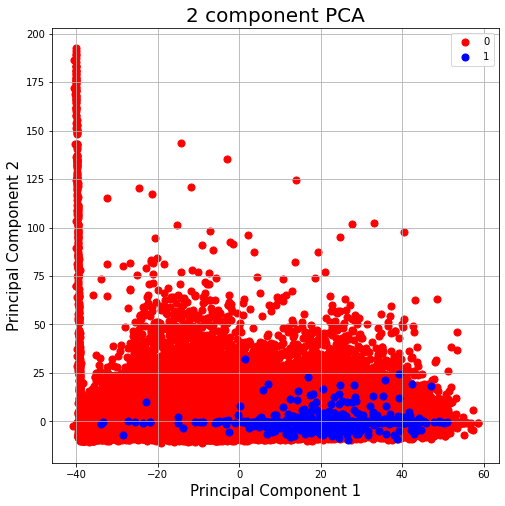

[0.80684909 0.09151061]
0.8983596916311523
[ 0.00280975  0.99773263  0.01196829  0.00496437  0.00182281 -0.00237965
  0.00258888 -0.00487189  0.04170285  0.05074714]


In [ ]:
PCA_custom('real_target', 2)

##### 3 components PCA

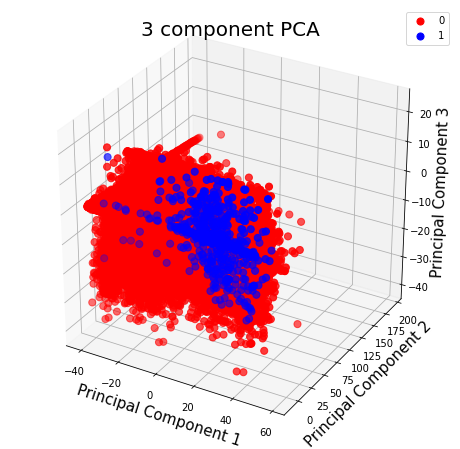

[0.80684909 0.09151061 0.06063894]
0.9589986350044433
[ 0.00280975  0.99773263  0.01196829  0.00496437  0.00182281 -0.00237965
  0.00258888 -0.00487189  0.04170285  0.05074714]


In [ ]:
PCA_custom('real_target', 3, coeffs=[1, 1, -1])

#### Target analyses

##### 2 components PCA

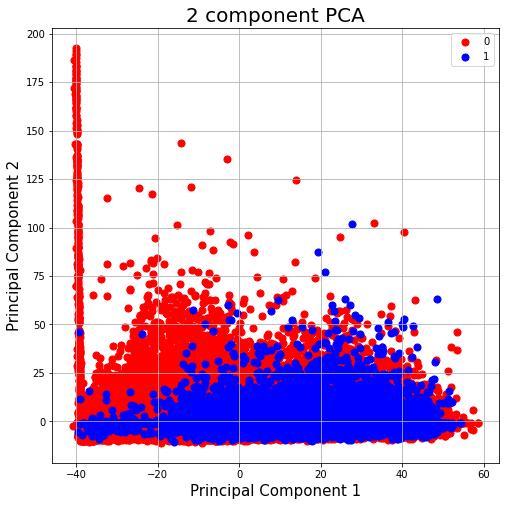

[0.80684909 0.09151061]
0.8983596916311503
[ 0.00280975  0.99773263  0.01196829  0.00496437  0.00182281 -0.00237965
  0.00258888 -0.00487189  0.04170285  0.05074714]


In [ ]:
PCA_custom('target', 2)

##### 3 components PCA

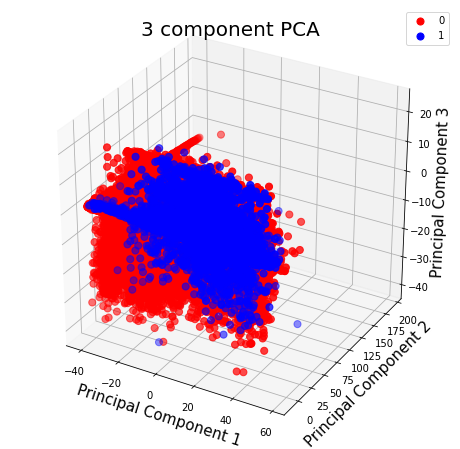

[0.80684909 0.09151061 0.06063894]
0.9589986350044437
[ 0.00280975  0.99773263  0.01196829  0.00496437  0.00182281 -0.00237965
  0.00258888 -0.00487189  0.04170285  0.05074714]


In [ ]:
PCA_custom('target', 3, coeffs=[1, 1, -1])

### checking and ploting distribution of features

In [ ]:
@interact
def check_distribution(feature=features, distribution=['norm', 'lognorm', 'exp']):
  x = normal[feature].dropna().sort_values()
  unique = np.unique(x)
  if unique.shape[0] > 2:
    krit=ks_critical_value(x.shape[0], alpha=0.05)
    print(krit)
    if distribution == 'norm':
      loc, scale = stats.norm.fit(x)
      params = f"μ={loc:.3f}, σ={scale:.3f}"
      dist = stats.norm(loc=loc, scale=scale)
    elif distribution == 'lognorm':
      shape, loc, scale= stats.lognorm.fit(x)
      params = f"loc={loc:.3f}, scale={scale:.3f}, shape={shape:.3f}"
      dist  = stats.lognorm(s=shape, loc=loc, scale=scale)
    else:
      loc, scale = stats.expon.fit(x)
      params = f"loc={loc:.3f}, scale={scale:.3f}"
      dist = stats.expon(loc=loc, scale=scale)
    test = stats.kstest(x, dist.cdf)
    print(test)
    if test[1] > 0.05:
      print(f"{feature} is distributed as {distribution}")
    else:
      print(f"{feature} is not distributed as {distribution}")
    x_p = np.linspace(x.min(), x.max(), 1000)
    plt.figure(figsize=(10,7))
    plt.plot(x_p, dist.pdf(x_p), alpha=0.6, label=f'Emperical pdf of {distribution} with {params}')
    sns.distplot(x, bins=100, label="PDF")
    plt.legend(loc='best')
    plt.savefig(f"/content/drive/My Drive/DS Project/images/dist_test_{feature}_{distribution}.jpg", quality=100)
    plt.show()
  else:
    print("This data is binary")

interactive(children=(Dropdown(description='feature', options=('gender', 'age', 'glucose_blood', 'glucose_urin…

In [ ]:
@interact(bins=(50, 1000, 50))
def get_distribution(feature=features, bins=100, CDF=False):
  if np.unique(normal[feature]).shape[0] != 2:
    if CDF:
      f, axes = plt.subplots(1, 2, figsize=(10, 7))
      sns.distplot(normal[feature], bins=bins, hist_kws={'cumulative': True}, kde_kws={'cumulative': True}, ax=axes[0], label="CDF")
      sns.distplot(normal[feature], bins=bins, label="PDF", ax=axes[1])
      axes[0].legend(loc='best')
      axes[1].legend(loc='best')
    else:
      plt.figure(figsize=(10,7))
      sns.distplot(normal[feature], bins=bins, label="PDF")
      plt.legend(loc='best')
  else:
    normal[feature].hist()
  if not CDF:
    plt.savefig(f"/content/drive/My Drive/DS Project/images/dist_{feature}.jpg", quality=100)
  else:
    plt.savefig(f"/content/drive/My Drive/DS Project/images/dist_cdf_{feature}.jpg", quality=100)
  plt.show()

interactive(children=(Dropdown(description='feature', options=('gender', 'age', 'glucose_blood', 'glucose_urin…

### get correlation of features

In [ ]:
features_

Index(['gender', 'age', 'glucose_blood', 'glucose_urine', 'HbA1C',
       'bilirubin_common', 'bilirubin_direct', 'bilirubin_indirect',
       'diastolic_bp', 'bmi'],
      dtype='object')

In [ ]:
@interact
def get_feature_corr(feature=list(features)+["real_target", "all"], dataframe_name=['nna', 'normal']):
  pd.options.display.float_format = '{:,.3f}'.format
  dataframe = nna if dataframe_name == 'nna' else normal
  corr = dataframe[list(features)+["real_target"]].corr()
  if feature != "all":
    corr = corr[feature]
    print(corr.sort_values())
  else:
    corr = corr.style.background_gradient(cmap='ocean')
    with open(f"/content/drive/My Drive/DS Project/images/corr{dataframe_name}.html", 'w') as f:
      f.write(corr._repr_html_())
    return corr

interactive(children=(Dropdown(description='feature', options=('gender', 'age', 'glucose_blood', 'glucose_urin…

### Description of features

In [ ]:
@interact
def describe_feature(feature=list(features)+["real_target", "all"]):
  if feature == "all":
    return normal.describe()
  else:
    if np.unique(normal[feature]).shape[0] != 2:
      return normal[feature].describe()
    else:
      return Counter(normal[feature])

interactive(children=(Dropdown(description='feature', options=('gender', 'age', 'glucose_blood', 'glucose_urin…

### plot for most affected features

In [ ]:
def get_cool_plot(label, weights=[1,1,1]):
  cool_features = ["glucose_blood", "HbA1C", "bmi", label]
  plot_df = nna[cool_features]
  fig = plt.figure(figsize = (8, 10))
  ax = fig.add_subplot(2,1,1,projection='3d') 
  ax1 = fig.add_subplot(2,1,2,projection='3d') 
  axes = ax, ax1
  for ax_ in axes:
    ax_.set_xlabel(cool_features[0], fontsize = 15)
    ax_.set_ylabel(cool_features[1], fontsize = 15)
    ax_.set_zlabel(cool_features[2], fontsize = 15)
    ax_.set_title(f'{label} to cool features', fontsize = 20)
  targets = [0, 1]
  colors = ['r', 'b']
  for target, color in zip(targets, colors):
      indicesToKeep = plot_df[label] == target
      if not target:
        ax.scatter(weights[0]*plot_df.loc[indicesToKeep, cool_features[0]]
                , weights[1]*plot_df.loc[indicesToKeep, cool_features[1]]
                , weights[2]*plot_df.loc[indicesToKeep, cool_features[2]]
                , c = color
                , s = 10)
      else:
        ax1.scatter(weights[0]*plot_df.loc[indicesToKeep, cool_features[0]]
                , weights[1]*plot_df.loc[indicesToKeep, cool_features[1]]
                , weights[2]*plot_df.loc[indicesToKeep, cool_features[2]]
                , c = color
                , s = 10)
  i = 0
  for ax_ in axes:
    ax_.legend([targets[i]])
    ax_.grid()
    i += 1
  plt.savefig(f"/content/drive/My Drive/DS Project/images/cool_features_{label}.jpg", quality=100)
  plt.show()

#### real target

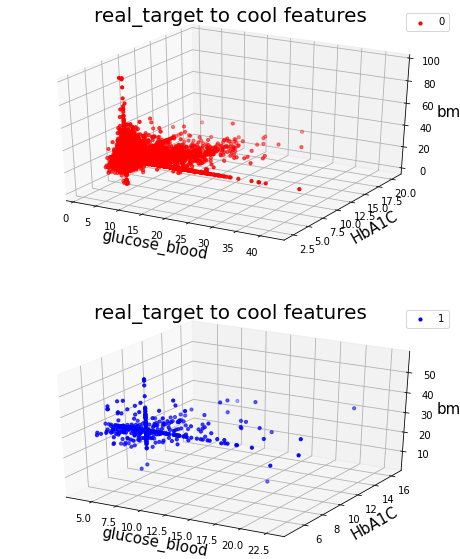

In [ ]:
get_cool_plot('real_target')

#### target

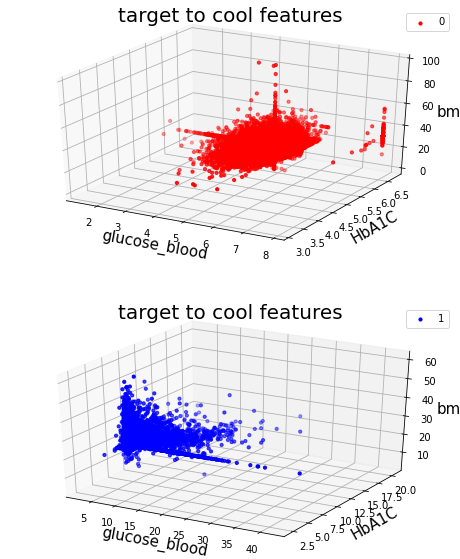

In [ ]:
get_cool_plot('target')

### TSNE

In [ ]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
def custom_TSNE(label, data=nna, cols=features_):
  y = real_target[['real_target']] if label == 'real_target' else target_df[['target']]
  print(f"[{datetime.now()}] Start")
  X = np.vstack([data[data[label]==i][cols]
               for i in range(2)])
  print(f"[{datetime.now()}] x stacked")
  y = np.hstack([y[y[label]==i][label]
                for i in range(2)])
  print(f"[{datetime.now()}] y stacked")
  X_embedded = TSNE(random_state=42, n_jobs=-1).fit_transform(X)
  print(f"[{datetime.now()}] TSNE done")
  scatter(X_embedded, y)
  plt.savefig(f'/content/drive/My Drive/DS Project/images/tsne-generated_{label}.png', dpi=120)

In [ ]:
# custom_TSNE('real_target')

In [ ]:
# custom_TSNE('real_target', cols=["glucose_blood", "HbA1C", "bmi"])

## Split normal data by sex

and repeat:
- check distribution;
- plot distribution;
- see correlation of features;

In [ ]:
man_df = normal[normal.gender == 1].drop(labels=['gender'], axis=1)

In [ ]:
women_df = normal[normal.gender == 0].drop(labels=['gender'], axis=1)

In [ ]:
m_features = man_df.columns[2:].drop(labels=['birthday'])

In [ ]:
@interact
def check_distribution(feature=m_features, distribution=['norm', 'lognorm']):
  x = man_df[feature].dropna().sort_values()
  unique = np.unique(x)
  if unique.shape[0] > 2:
    krit=ks_critical_value(x.shape[0], alpha=0.05)
    print(krit)
    if distribution == 'norm':
      loc, scale = stats.norm.fit(x)
      params = f"μ={loc:.3f}, σ={scale:.3f}"
      dist = stats.norm(loc=loc, scale=scale)
    elif distribution == 'lognorm':
      shape, loc, scale= stats.lognorm.fit(x)
      params = f"loc={loc:.3f}, scale={scale:.3f}, shape={shape:.3f}"
      dist  = stats.lognorm(s=shape, loc=loc, scale=scale)
    else:
      loc, scale = stats.expon.fit(x)
      params = f"loc={loc:.3f}, scale={scale:.3f}"
      dist = stats.expon(loc=loc, scale=scale)
    test = stats.kstest(x, dist.cdf)
    print(test)
    if test[1] > 0.05:
      print(f"{feature} is distributed as {distribution}")
    else:
      print(f"{feature} is not distributed as {distribution}")
    x_p = np.linspace(x.min(), x.max(), 1000)
    plt.figure(figsize=(10,7))
    plt.plot(x_p, dist.pdf(x_p), alpha=0.6, label=f'Emperical pdf of {distribution} with {params}')
    sns.distplot(x, bins=100, label="PDF")
    plt.legend(loc='best')
    plt.savefig(f"/content/drive/My Drive/DS Project/images/dist_test_{feature}_{distribution}.jpg", quality=100)
    plt.show()
  else:
    print("This data is binary")

interactive(children=(Dropdown(description='feature', options=('age', 'glucose_blood', 'glucose_urine', 'HbA1C…

In [ ]:
@interact
def get_distribution(feature=m_features):
  plt.figure(figsize=(10, 7))
  if np.unique(man_df[feature]).shape[0] != 2:
    sns.distplot(man_df[feature], bins=100)
  else:
    man_df[feature].hist()
  plt.show()

interactive(children=(Dropdown(description='feature', options=('age', 'glucose_blood', 'glucose_urine', 'HbA1C…

In [ ]:
@interact
def check_distribution(feature=m_features, distribution=['norm', 'lognorm']):
  x = women_df[feature].dropna().sort_values()
  unique = np.unique(x)
  if unique.shape[0] > 2:
    # print(mode)
    krit=ks_critical_value(x.shape[0], alpha=0.05)
    print(krit, x.shape[0])
    if distribution == 'norm':
      loc, scale = stats.norm.fit(x)
      dist = stats.norm(loc=loc, scale=scale)
    else:
      shape, loc, scale= stats.lognorm.fit(x)
      dist  = stats.lognorm(s=shape, loc=loc, scale=scale)
    test = stats.kstest(x, dist.cdf)
    print(test)
    if test[1] > 0.05:
      print(f"{feature} is distributed as {distribution}")
    else:
      print(f"{feature} is not distributed as {distribution}")
  else:
    print("This data is binary")

interactive(children=(Dropdown(description='feature', options=('age', 'glucose_blood', 'glucose_urine', 'HbA1C…

In [ ]:
@interact
def get_distribution(feature=m_features):
  plt.figure(figsize=(10, 7))
  if np.unique(women_df[feature]).shape[0] != 2:
    sns.distplot(women_df[feature], bins=100)
  else:
    women_df[feature].hist()
  plt.show()

interactive(children=(Dropdown(description='feature', options=('age', 'glucose_blood', 'glucose_urine', 'HbA1C…

# Building model

## split data

In [ ]:
features_

Index(['gender', 'age', 'glucose_blood', 'glucose_urine', 'HbA1C',
       'bilirubin_common', 'bilirubin_direct', 'bilirubin_indirect',
       'diastolic_bp', 'bmi'],
      dtype='object')

In [ ]:
features_ng = features_.drop(labels=['glucose_blood', 'glucose_urine'])
X = nna[features_ng]

In [ ]:
y=real_target['real_target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 146822, 1: 526})
Counter({0: 36706, 1: 132})


In [ ]:
rus = RandomUnderSampler(random_state=42, ratio=.01)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 65800, 1: 658})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## RandomForest

### Classification

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rfc.predict(X_test)

### Evaluation

#### confusion matrix and classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36706
           1       1.00      0.93      0.96       132

    accuracy                           1.00     36838
   macro avg       1.00      0.97      0.98     36838
weighted avg       1.00      1.00      1.00     36838



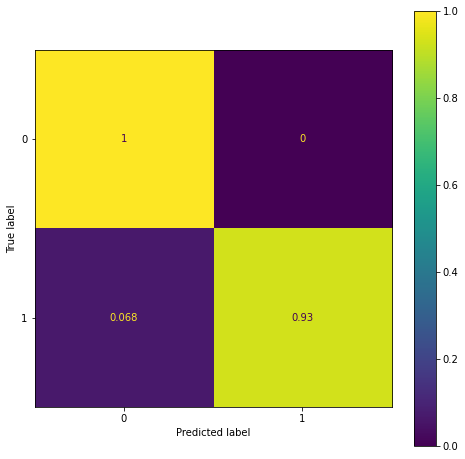

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(rfc, X_test, y_test, normalize='true', ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/rfc_confusion_matrix_normolized.jpg", quality=100)

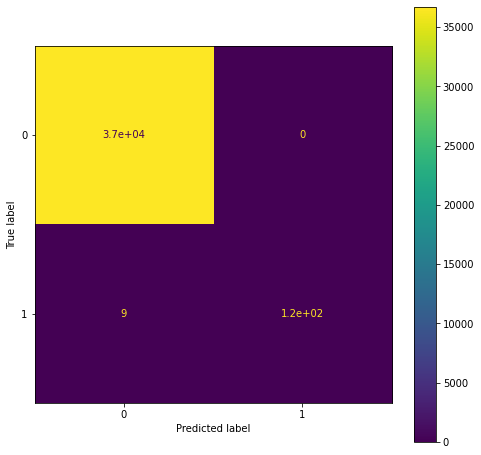

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(rfc, X_test, y_test, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/rfc_confusion_matrix.jpg", quality=100)

#### ROC & AUC score and plotting

In [ ]:
prob_y_rfc = rfc.predict_proba(X)
prob_y_rfc = [p[1] for p in prob_y_rfc]
print( roc_auc_score(y, prob_y_rfc) )

0.9976973193028926


In [ ]:
prob_y_rfc = rfc.predict_proba(X_test)
prob_y_rfc.shape

(36838, 2)

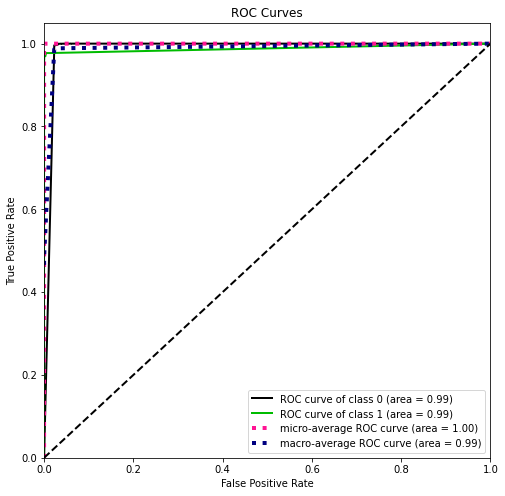

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_roc(y_test, prob_y_rfc, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/rfc_roc.jpg", quality=100)
plt.show()

#### Feature importance

In [ ]:
feature_imp = pd.Series(rfc.feature_importances_,index=features_ng).sort_values(ascending=False)
feature_imp

HbA1C                0.302
bmi                  0.273
bilirubin_common     0.122
bilirubin_indirect   0.122
bilirubin_direct     0.109
diastolic_bp         0.042
age                  0.028
gender               0.002
dtype: float64

No handles with labels found to put in legend.


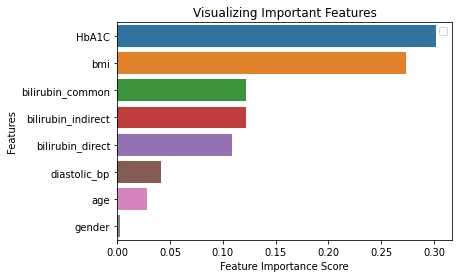

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## SVM with custom weight

### Classification

In [ ]:
print(f"[{datetime.now()}] started init")
clf_svm = svm.SVC(kernel='rbf', class_weight={1: 10}, verbose=True, probability=True)
start=datetime.now()
print(f"[{start}] started fit")
clf_svm.fit(X_train, y_train)
end=datetime.now()
print(f"[{end}] Ended fit in {(end-start).total_seconds()}")

[2020-05-30 17:11:02.762548] started init
[2020-05-30 17:11:02.762865] started fit
[LibSVM][2020-05-30 17:16:35.068796] Ended fit in 332.305931


In [ ]:
y_pred = clf_svm.predict(X_test)

### Evaluation

#### confusion matrix and classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     36706
           1       0.24      0.50      0.32       132

    accuracy                           0.99     36838
   macro avg       0.62      0.75      0.66     36838
weighted avg       1.00      0.99      0.99     36838



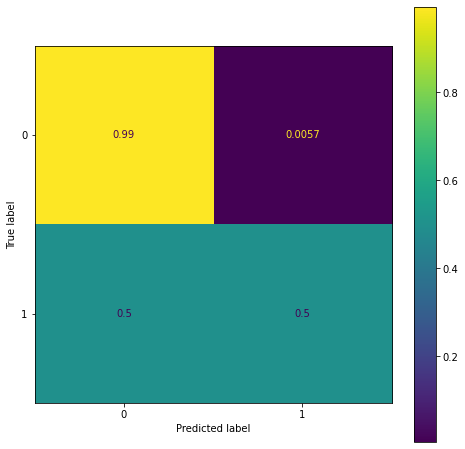

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(clf_svm, X_test, y_test, normalize='true', ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/svm_cw_confusion_matrix_normolized.jpg", quality=100)

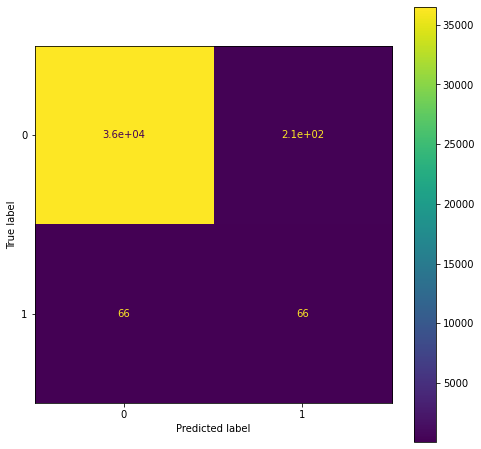

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(clf_svm, X_test, y_test, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/svm_confusion_matrix.jpg", quality=100)

#### ROC & AUC score and plotting

In [ ]:
prob_y_svm = clf_svm.predict_proba(X)
prob_y_svm = [p[1] for p in prob_y_svm]
print( roc_auc_score(y, prob_y_svm) )

0.981723066630947


In [ ]:
prob_y_svm = clf_svm.predict_proba(X_test)
prob_y_svm.shape

(36838, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


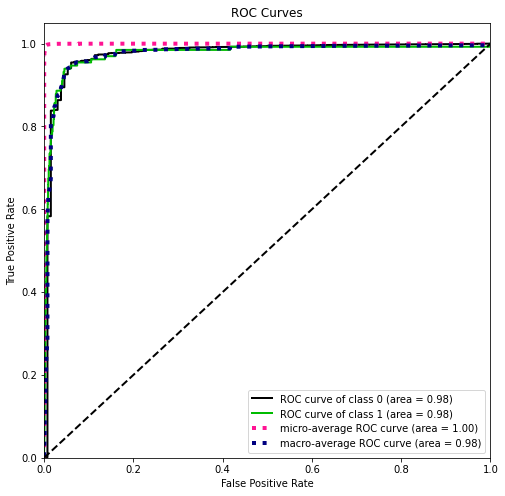

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_roc_curve(y_test, prob_y_svm, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/svm_cw_roc.jpg", quality=100)
plt.show()

## Gradient boosting (sklearn)

### Classification

In [ ]:
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

### Evaluation

#### confusion matrix and classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36706
           1       0.98      0.81      0.89       132

    accuracy                           1.00     36838
   macro avg       0.99      0.91      0.94     36838
weighted avg       1.00      1.00      1.00     36838



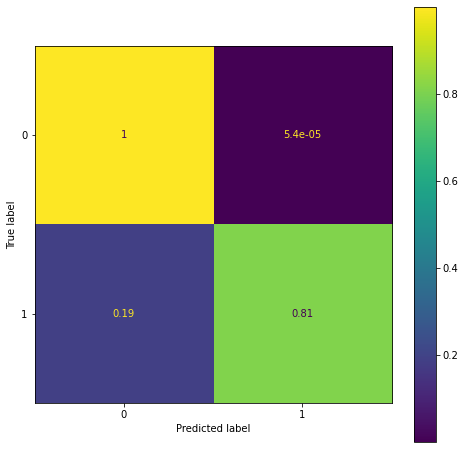

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(gbc, X_test, y_test, normalize='true', ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/gbc_confusion_matrix_normolized.jpg", quality=100)

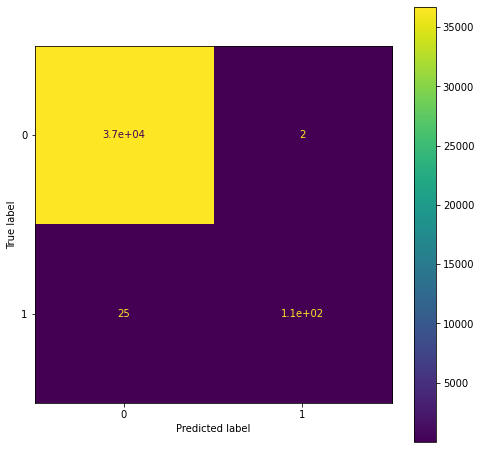

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(gbc, X_test, y_test, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/gbc_confusion_matrix.jpg", quality=100)

#### ROC & AUC score and plotting

In [ ]:
prob_y_gbc = gbc.predict_proba(X)
prob_y_gbc = [p[1] for p in prob_y_gbc]
print( roc_auc_score(y, prob_y_gbc) )

0.9045134230944478


In [ ]:
prob_y_gbc = gbc.predict_proba(X_test)
prob_y_gbc.shape

(36838, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


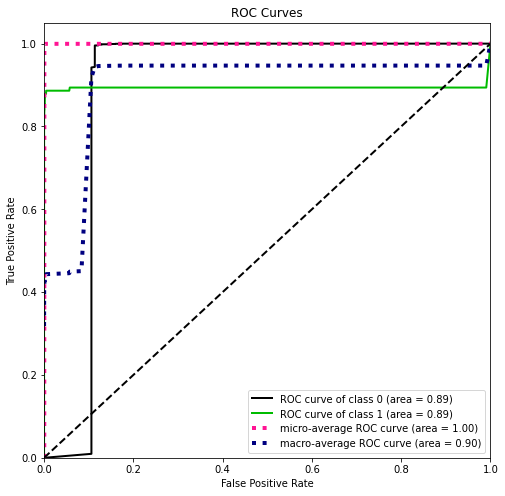

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_roc_curve(y_test, prob_y_gbc, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/gbc_roc.jpg", quality=100)
plt.show()

#### Feature importance

In [ ]:
feature_imp = pd.Series(gbc.feature_importances_,index=features_ng).sort_values(ascending=False)
feature_imp

HbA1C                0.639
bmi                  0.356
bilirubin_common     0.002
bilirubin_indirect   0.002
diastolic_bp         0.001
bilirubin_direct     0.000
age                  0.000
gender               0.000
dtype: float64

No handles with labels found to put in legend.


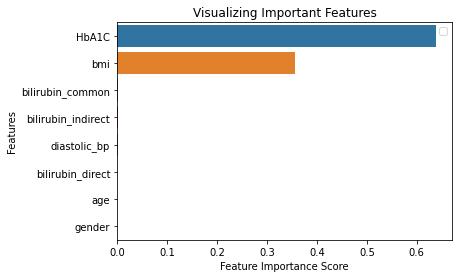

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## XGBOOST

### classification

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb_model.predict(X_test)

### evaluation

#### confusion matrix and classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36706
           1       0.98      0.92      0.95       132

    accuracy                           1.00     36838
   macro avg       0.99      0.96      0.97     36838
weighted avg       1.00      1.00      1.00     36838



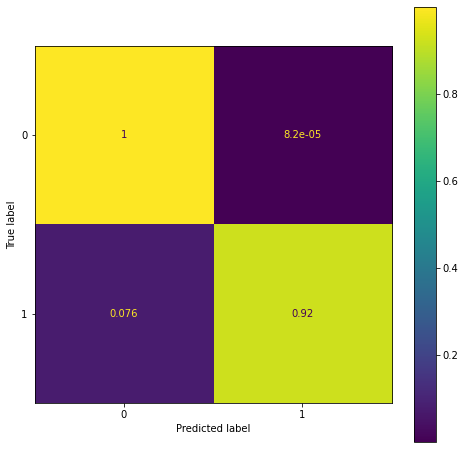

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(xgb_model, X_test, y_test, normalize='true', ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/xgboost_confusion_matrix_normolized.jpg", quality=100)

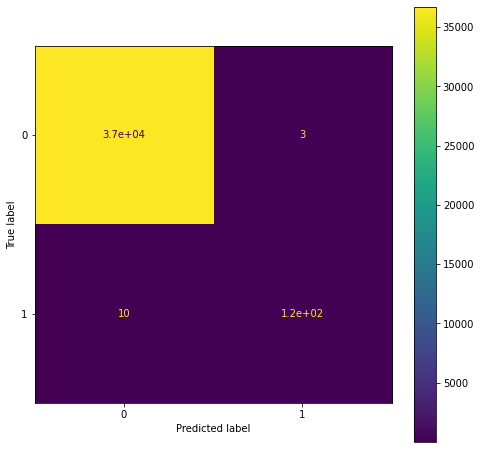

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(xgb_model, X_test, y_test, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/xgboost_confusion_matrix.jpg", quality=100)

#### ROC & AUC score and plotting

In [ ]:
prob_y_xgb = xgb_model.predict_proba(X)
prob_y_xgb = [p[1] for p in prob_y_xgb]
print( roc_auc_score(y, prob_y_xgb) )

0.9999437734354639


In [ ]:
prob_y_xgb = xgb_model.predict_proba(X_test)
prob_y_xgb.shape

(36838, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


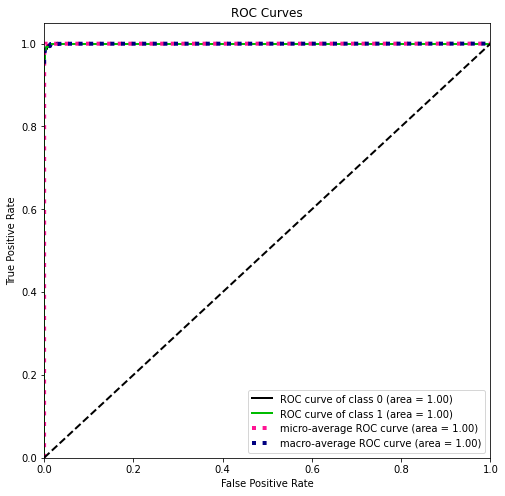

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_roc_curve(y_test, prob_y_xgb, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/xgboost_roc.jpg", quality=100)
plt.show()

#### Feature importance

In [ ]:
feature_imp = pd.Series(xgb_model.feature_importances_,index=features_ng).sort_values(ascending=False)
feature_imp

HbA1C                0.372
bmi                  0.204
bilirubin_common     0.181
bilirubin_indirect   0.095
diastolic_bp         0.068
bilirubin_direct     0.054
age                  0.026
gender               0.000
dtype: float32

No handles with labels found to put in legend.


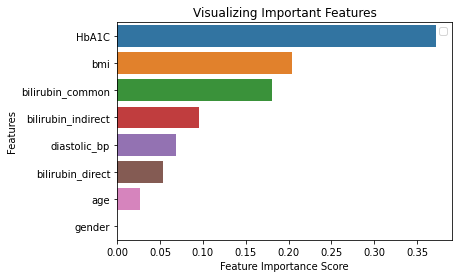

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## CatBoost

### classsification

In [ ]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [ ]:
model = CatBoostClassifier(iterations=10,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    # eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1357856	total: 63ms	remaining: 567ms
1:	learn: 0.0488798	total: 74.5ms	remaining: 298ms
2:	learn: 0.0233430	total: 85.1ms	remaining: 199ms
3:	learn: 0.0122131	total: 95.8ms	remaining: 144ms
4:	learn: 0.0073057	total: 106ms	remaining: 106ms
5:	learn: 0.0055151	total: 116ms	remaining: 77.6ms
6:	learn: 0.0038764	total: 127ms	remaining: 54.4ms
7:	learn: 0.0032112	total: 138ms	remaining: 34.4ms
8:	learn: 0.0030866	total: 148ms	remaining: 16.4ms
9:	learn: 0.0027573	total: 158ms	remaining: 0us


In [ ]:
y_pred = model.predict(X_test)

### Evaluation

#### confusion matrix and classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36706
           1       0.92      0.85      0.88       132

    accuracy                           1.00     36838
   macro avg       0.96      0.92      0.94     36838
weighted avg       1.00      1.00      1.00     36838



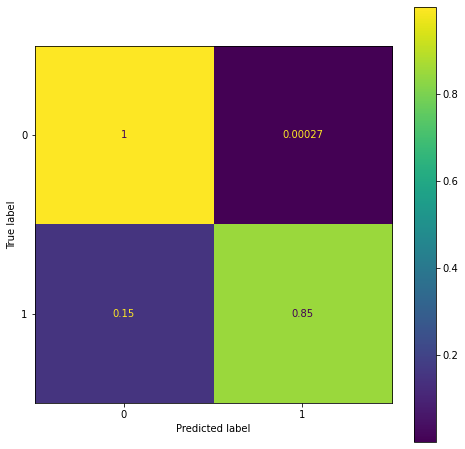

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(model, X_test, y_test, normalize='true', ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/catboost_confusion_matrix_normolized.jpg", quality=100)

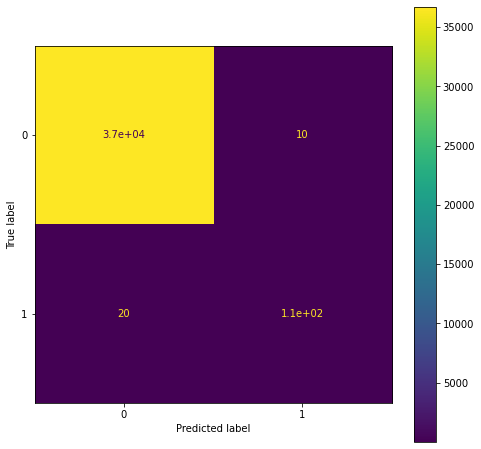

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/catboost_confusion_matrix.jpg", quality=100)

#### ROC & AUC score and plotting

In [ ]:
prob_y_catboost = model.predict_proba(X)
prob_y_catboost = [p[1] for p in prob_y_catboost]
print( roc_auc_score(y, prob_y_catboost) )

0.9986685276251793


In [ ]:
prob_y_catboost = model.predict_proba(X_test)
prob_y_catboost.shape

(36838, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


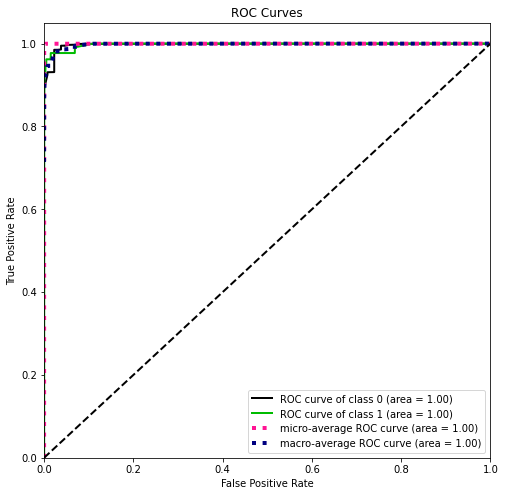

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_roc_curve(y_test, prob_y_catboost, ax=ax)
plt.savefig(f"/content/drive/My Drive/DS Project/images/catboost_roc.jpg", quality=100)
plt.show()

#### Feature importance

In [ ]:
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices))

In [ ]:
feature_imp = pd.Series(feature_importances,index=features_ng).sort_values(ascending=False)
feature_imp

bmi                  51.891
HbA1C                45.277
diastolic_bp          2.832
bilirubin_common      0.000
bilirubin_indirect    0.000
bilirubin_direct      0.000
age                   0.000
gender                0.000
dtype: float64

No handles with labels found to put in legend.


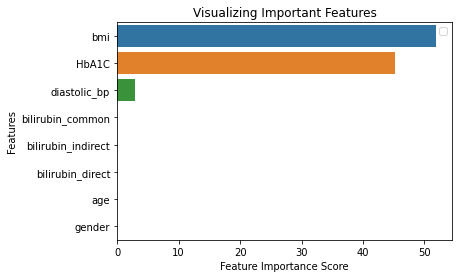

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()